<a href="https://colab.research.google.com/github/lam-01/Code_TextSummarization/blob/main/TextSummarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
reviewsData=pd.read_csv("/content/drive/MyDrive/Reviews.csv",nrows=30000) #Nhận 30.000 trên 500.000 đánh giá
print(reviewsData.shape) #Phân tích hình dạng của tập dữ liệu
reviewsData.head(n=10)

(30000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [ ]:
reviewsData.drop(['Id', 'ProductId', 'UserId', 'ProfileName' , 'HelpfulnessNumerator' , 'HelpfulnessDenominator', 'Score' ,'Time'],axis = 1 ,inplace = True)
reviewsData.head(n=10)

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,"Wonderful, tasty taffy",This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,Yay Barley,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,Healthy Dog Food,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [ ]:
reviewsData.drop_duplicates(subset=['Text'],inplace=True)
reviewsData.dropna(axis=0,inplace=True)

In [ ]:
reviewsData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28677 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  28677 non-null  object
 1   Text     28677 non-null  object
dtypes: object(2)
memory usage: 672.1+ KB


In [ ]:
# Tiền xử lí

contraction_mapping = {"isn't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
# Làm sạch văn bản
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    if(num==0):
      tokens = [w for w in newString.split() if not w in stop_words]
    else :
      tokens = newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                  # xóa các câu ngắn
            long_words.append(i)
    return (" ".join(long_words)).strip()

# Gọi hàm
cleaned_text = []
for t in reviewsData['Text']:
    cleaned_text.append(text_cleaner(t,0))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
reviewsData['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [ ]:
cleaned_text[:10]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces kids husband l

In [ ]:
# Làm sạch summary
cleaned_summary = []
for t in reviewsData['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [ ]:
reviewsData['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [ ]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [ ]:
reviewsData['Cleaned_Text'] = cleaned_text  # Thêm văn bản đã được làm sạch vào tập dữ liệu
reviewsData['Cleaned_Summary'] = cleaned_summary  # Thêm tóm tắt đã được làm sạch vào tập dữ liệu
# Xóa hàng trống
reviewsData['Cleaned_Summary'].replace('', np.nan, inplace=True)
# Xóa hàng có giá trị thiếu
reviewsData.dropna(axis=0,inplace=True)

In [ ]:
# Trước khi làm sạch
print("Before Preprocessing:\n")
for i in range(5):
    print("Review:",reviewsData['Text'][i])
    print("Summary:",reviewsData['Summary'][i])
    print("\n")

Before Preprocessing:

Review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Summary: Good Quality Dog Food


Review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Summary: Not as Advertised


Review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat t

In [ ]:
# In văn bản đã làm sạch và tóm tắt sẽ hoạt động như đầu vào cho mô hình
print("After Preprocessing:\n")
for i in range(5):
    print("Review:",reviewsData['Cleaned_Text'][i])
    print("Summary:",reviewsData['Cleaned_Summary'][i])
    print("\n")

After Preprocessing:

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: good quality dog food


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: not as advertised


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: delight says it all


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: cough medicine


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary: great taffy




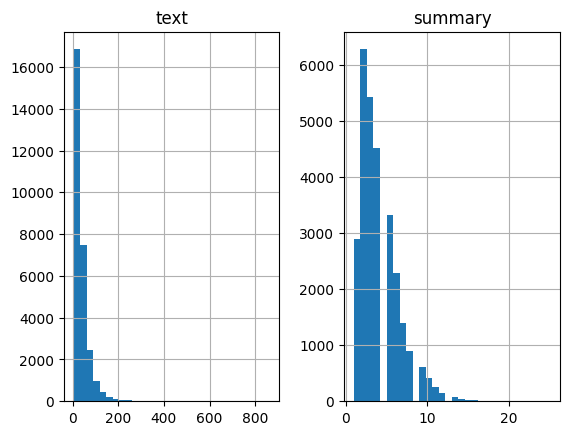

In [ ]:
# Trực quan hóa dữ liệu
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# Điền vào danh sách với độ dài câu
for i in reviewsData['Cleaned_Text']:
      text_word_count.append(len(i.split()))

for i in reviewsData['Cleaned_Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
# Lấy độ dài review tối đa
count=0
for i in reviewsData['Cleaned_Text']:
    if(len(i.split())<=35):
        count=count+1
print(count/len(reviewsData['Cleaned_Text']))

0.630776211084741


In [ ]:
# Lấy độ dài summary tối đa
count=0
for i in reviewsData['Cleaned_Summary']:
    if(len(i.split())<=8):
        count=count+1
print(count/len(reviewsData['Cleaned_Summary']))

0.9437386569872959


In [ ]:
# Độ dài tối đa của review và summary
max_text_len = 35
max_summary_len = 10

In [ ]:
# Thêm thẻ START và END vào tóm tắt để giải mã tốt hơn
cleaned_text =np.array(reviewsData['Cleaned_Text'])
cleaned_summary=np.array(reviewsData['Cleaned_Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
df['summary']

0                             sostok good quality dog food eostok
1                                 sostok not as advertised eostok
2                                    sostok cough medicine eostok
3                                       sostok great taffy eostok
4        sostok great just as good as the expensive brands eostok
                                   ...                           
17886                          sostok gluten free goodness eostok
17887                             sostok gluten free bread eostok
17888                              sostok pamela bread mix eostok
17889                                   sostok great bread eostok
17890      sostok great price on great gluten free product eostok
Name: summary, Length: 17891, dtype: object

In [ ]:
# Tách tập dữ liệu
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=0,shuffle=True)

In [ ]:
# Chuẩn bị Tokenizer

# Văn bản Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Chuẩn bị một tokenizer để đánh giá về dữ liệu train
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

In [ ]:
# Từ hiếm trong review
thresh = 4

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in X_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 65.64031254138524
Total Coverage of rare words: 4.895365955018983


In [ ]:
# Xác định Tokenizer với các từ phổ biến nhất hàng đầu để đánh giá

X_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
X_tokenizer.fit_on_texts(list(X_train))

# Chuyển đổi chuỗi văn bản thành chuỗi số nguyên
X_train_seq    =   X_tokenizer.texts_to_sequences(X_train)
X_test_seq   =   X_tokenizer.texts_to_sequences(X_test)

# Phần đệm không có chiều dài tối đa
X_train    =   pad_sequences(X_train_seq,  maxlen = max_text_len, padding = 'post')
X_test   =   pad_sequences(X_test_seq, maxlen = max_text_len, padding = 'post')

# Kích thước từ vựng (+1 cho token)
X_voc   =  X_tokenizer.num_words + 1

In [ ]:
X_voc

5190

In [ ]:
# Tóm tắt Tokenizer

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
# Tóm tắt về những từ hiếm và phạm vi của chúng

thresh = 6  # Nếu một từ có số lượng nhỏ hơn ngưỡng tức là 6, thì nó được coi là từ hiếm

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        cnt = cnt+1
        freq = freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.40912667191188
Total Coverage of rare words: 8.85671402323836


In [ ]:
# Tóm tắt Tokenizer bằng những từ thông dụng

y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_train))

# Chuyển đổi chuỗi văn bản thành chuỗi số nguyên
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train)
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test)

# Phần đệm không có chiều dài tối đa
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

# Kích thước của từ vựng
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_voc

997

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_train)

(14312, 14312)

In [ ]:
# Xóa các hàng chứa token START và END
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
       # Tạo một biến trọng số có thể huấn luyện cho lớp này.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]


        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Tính toán đầu ra  """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Tính toán vectơ ngữ cảnh """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Đầu ra được tạo ra bởi lớp """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from keras import backend as K
K.clear_session()  # Đặt lại tất cả trạng thái được tạo bởi Keras

latent_dim = 256
embedding_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#Setting up the Decoder using 'encoder_states' as initial state
decoder_inputs = Input(shape=(None,))

#Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#Concating Attention input and Decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

#Defining the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              1328640   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 35, 256),            525312    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
#Training the Model
history = model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size= 64, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/50
215/215 [==============================] - 406s 2s/step - loss: 2.3477 - accuracy: 0.6427 - val_loss: 2.0009 - val_accuracy: 0.6880
Epoch 2/50
215/215 [==============================] - 398s 2s/step - loss: 2.0611 - accuracy: 0.6766 - val_loss: 1.9428 - val_accuracy: 0.6885
Epoch 3/50
215/215 [==============================] - 348s 2s/step - loss: 1.9964 - accuracy: 0.6771 - val_loss: 1.8875 - val_accuracy: 0.6889
Epoch 4/50
215/215 [==============================] - 361s 2s/step - loss: 1.9452 - accuracy: 0.6788 - val_loss: 1.8479 - val_accuracy: 0.6912
Epoch 5/50
215/215 [==============================] - 341s 2s/step - loss: 1.9028 - accuracy: 0.6818 - val_loss: 1.8235 - val_accuracy: 0.6946
Epoch 6/50
215/215 [==============================] - 375s 2s/step - loss: 1.8715 - accuracy: 0.6838 - val_loss: 1.8045 - val_accuracy: 0.6949
Epoch 7/50
215/215 [==============================] - 353s 2s/step - loss: 1.8420 - accuracy: 0.6852 - val_loss: 1.7924 - val_accuracy: 0.6961

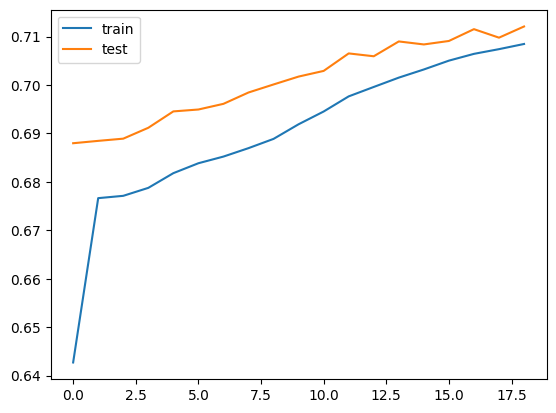

In [ ]:
# Trực quan hóa độ chính xác
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

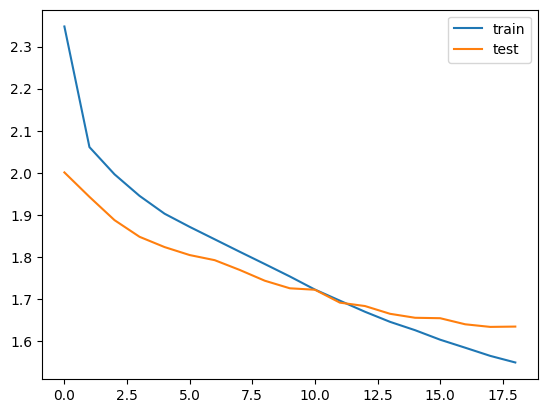

In [ ]:
# Trực quan hóa sự mất mát
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# Xây dựng từ điển cho từ vựng
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=X_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:

# Mã hóa chuỗi đầu vào để lấy vectơ đặc trưng
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder

# Các tensor này sẽ giữ trạng thái của bước thời gian trước đó
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Lấy phần nhúng của chuỗi bộ giải mã
dec_emb2= dec_emb_layer(decoder_inputs)

 #Đặt trạng thái ban đầu thành trạng thái từ bước thời gian trước đó để dự đoán tốt hơn
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Attention
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Thêm lớp softmax dày đặc để tạo phân phối khả năng trên từ vựng mục tiêu
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Mô hình decoder
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# Hàm xác định việc thực hiện quá trình suy luận
def decode_sequence(input_seq):
    # Mã hóa đầu vào dưới dạng vectơ trạng thái
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Tạo chuỗi mục tiêu trống có độ dài 1
    target_seq = np.zeros((1,1))

    # Điền từ đầu tiên của chuỗi mục tiêu bằng từ bắt đầu
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Lấy mẫu token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Điều kiện thoát: nhấn độ dài tối đa hoặc tìm từ dừng
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Cập nhật chuỗi mục tiêu (có độ dài 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Cập nhật trạng thái
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
# Tóm tắt được tạo bởi mô hình

for i in range(0,20):
    print("Review:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1,max_text_len)))
    print("\n")

Review: get local health food store price sucks one best tasting coconut waters around though 
Original summary: love the water hate the price 
1/1 [==============================] - 0s 27ms/step
Predicted summary:  great product


Review: nervous ordering one reviewer said fresh ordered two bags problem rat terrier daughter standard schnauzer love food several brands flavors found food coats beautiful digest product well 
Original summary: arrived quickly and it was fresh 
1/1 [==============================] - 0s 25ms/step
Predicted summary:  great product


Review: bought medium roast noticed got actually extra bold dark intense bitter 
Original summary: strong but good tasting 
1/1 [==============================] - 0s 27ms/step
Predicted summary:  great coffee


Review: lab enjoys toy rope attached could get treats using tiny treats destroyed rope minutes treats fall 
Original summary: is weak 
1/1 [==============================] - 0s 30ms/step
Predicted summary:  great product



In [ ]:
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_train[i])
  candidate = decode_sequence(X_train[i].reshape(1, max_text_len))

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)

1/1 [==============================] - 0s 57ms/step
1.3483065280626046e-231


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,1000):
  reference = seq2summary(y_train[i])
  candidate = decode_sequence(X_train[i].reshape(1, max_text_len))

print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

1/1 [==============================] - 0s 34ms/step
Individual 1-gram: 0.300000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


In [ ]:
from rouge_score import rouge_scorer

# Hàm chuyển đổi chuỗi tóm tắt thành chuỗi văn bản
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for i in range(0, 1000):
    reference = seq2summary(y_train[i])
    candidate = decode_sequence(X_train[i].reshape(1, max_text_len))

    # Đảm bảo reference và candidate là chuỗi
    if isinstance(reference, np.ndarray):
        reference = " ".join(reference)
    if isinstance(candidate, np.ndarray):
        candidate = " ".join(candidate)

    # Tính toán điểm ROUGE
    scores = scorer.score(reference.lower(), candidate.lower())

    # Lưu trữ điểm số cho mỗi mẫu
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Tính điểm trung bình cho mỗi loại ROUGE
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print('Average ROUGE-1 F1 Score: %f' % avg_rouge1)
print('Average ROUGE-2 F1 Score: %f' % avg_rouge2)
print('Average ROUGE-L F1 Score: %f' % avg_rougeL)


1/1 [==============================] - 0s 35ms/step
Average ROUGE-1 F1 Score: 0.132679
Average ROUGE-2 F1 Score: 0.024928
Average ROUGE-L F1 Score: 0.131664


In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=5cb42d9a53154494c9123c23f6993a6fd597e3b3e0924c7cfd317a1a25079a99
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
